In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from multiprocessing.dummy import Pool as ThreadPool

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [117]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model
    

    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
        if (model_name == 'Random Forest Regressor'):
            for ypr in ypred:
                if ypr < 0:
                    ypr = 0
                elif ypr > 4:
                    ypr = 4
                else:
                    ypr = round(ypr)
        
        RMS=0
        for yp,yt in zip(ypred,y):
            RMS += ((yp - yt)**2)
        RMS = RMS / len(y)
        RMS = math.sqrt(RMS)
        
        RMS_all.append(RMS)
        
        groupres[model_name] = {'RMS':RMS_all}
        
        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [118]:
datadict = {'watch':{},'sensor':{}}
for freq in [50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Y:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['watch'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Y:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['sensor'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)

In [119]:
t1=time.time()
results = {}

for mode in ['watch','sensor']:

    results[mode] = {}

    for symptom in ['Tremor','Bradykinesia']:
        
        count = 0
        print(mode + ', ' + symptom)
        results[mode][symptom] = {}

        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = []

        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = pd.DataFrame()

        results[mode][symptom]['Regressor'] = {}
        regress_res_all = pd.DataFrame()
        regress_res_groups = pd.DataFrame()

        for freq in datadict[mode].keys():

            count += 1
            print('Frequency %d of %d'%(count,len(datadict[mode].keys())))
            data = datadict[mode][freq]
            Data = data.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()]
            Data=Data.reset_index(drop=True) #reset index

            if (mode == 'sensor') and (symptom == 'Tremor'):
                Data = Data.iloc[:,:49]
            
            X = Data.iloc[:,5:].values
            fnames = Data.iloc[:,5:].columns.values
            groups = Data.Subject.values

            #Binary

            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups.append(res_group)

            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            multi_res_groups = pd.concat((multi_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(multi_res_groups[multi_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest']
            R['Sampling Rate'] = [str(freq) + ' Hz']
            multi_res_all = pd.concat([multi_res_all,R])

            #Regressor

            y = Data[symptom].values.astype(int) #target 

            model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest Regressor']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            regress_res_groups = pd.concat((regress_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest'] 
            R['Sampling Rate'] = [str(freq) + ' Hz']
            regress_res_all = pd.concat([regress_res_all,R])

        results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
        results[mode][symptom]['Binary']['res_groups'] = binary_res_groups
        
        results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
        results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups
        
        results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
        results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups
        
f = open('Y:\\CIS-PD Study\\DownsampleAnalysisResults','wb')
pickle.dump(results,f)
f.close()

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

watch, Tremor
Frequency 1 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 2 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 3 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 4 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 5 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 6 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 7 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 8 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  r

Training Random Forest
Training Random Forest Regressor
watch, Bradykinesia
Frequency 1 of 8
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 2 of 8
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 3 of 8
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 4 of 8
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 5 of 8
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 6 of 8
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 7 of 8
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 8 of 8
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
sensor, Tremor
Frequency 1 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 2 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 3 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 4 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 5 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 6 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 7 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 8 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest Regressor
Frequency 9 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  r

Training Random Forest
Training Random Forest Regressor
Frequency 10 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  r

Training Random Forest
Training Random Forest Regressor
sensor, Bradykinesia
Frequency 1 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 2 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 3 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 4 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 5 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 6 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 7 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 8 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 9 of 10
Training Random Forest
Training Random Forest
Training Random Forest Regressor
Frequency 10 of 10
Training Random Forest


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


Training Random Forest
Training Random Forest Regressor
Elapsed time = 178.144 min


In [120]:
#Open results as pickle file

#f = open('Y:\\CIS-PD Study\\DownsampleAnalysisResults','rb')
#results = pickle.load(f)
#f.close()

In [128]:
def barplotFreq(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = results[mode][symptom][classifier]['res_all']['Sampling Rate'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
    else:
        groups = results[mode][symptom][classifier]['res_groups']['Sampling Rate']
        RMS = results[mode][symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[mode][symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.title('%s Model Performance v. %s Frequency: %s'%(classifier,mode,symptom))
    
    plt.savefig('Results/Resample_%s_%s_%s.png'%(mode,symptom,classifier),format='png',dpi=1000)

In [164]:
def stats_tests(mode,symptom,classifier):
    df = pd.DataFrame()
    freqlist = list(results[mode][symptom][classifier]['res_all']['Sampling Rate'])
    if classifier == 'Binary':
        for i in range(len(freqlist)):
            freq = freqlist[i]
            df[freq] = pd.Series(results[mode][symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['50 Hz'].isnull()].reset_index(drop=True)
    else:
        for freq in freqlist:
            df[freq] = results[mode][symptom][classifier]['res_groups'][results[mode][symptom][classifier]['res_groups']['Sampling Rate']==freq]['RMS']
        df = df.reset_index(drop=True)
    
    print('Repeated Measures ANOVA')
    cols = [freqlist[0]]
    for freq in freqlist[1:]:
        cols = cols + [freq]
        p = rmANOVA(df,cols)
        print(', '.join(cols))
        print('p-value: ' + str(p))
        print()
        
    d = results[mode][symptom][classifier]['res_all']
    if classifier == 'Binary':
        f = d[d.auroc == max(d.auroc)]['Sampling Rate'].values[0]
        print('Maximum AUROC: %s'%f)
        print()
    else:
        f = d[d.RMS == min(d.RMS)]['Sampling Rate'].values[0]
        print('Minimum RMS: %s'%f)
        print()
    for freq in freqlist:
        if freq == f:
            continue
        print('%s, %s'%(f,freq))
        print(stats.ttest_rel(df[f],df[freq]))

In [165]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return stats.f.sf(F,dfbw,dferror)

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.2455032644727299

50 Hz, 40 Hz, 30 Hz
p-value: 0.17770629369901836

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.018543926592302095

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 2.086725062269066e-05

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 1.969093144657875e-07

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 2.471282794347929e-07

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 6.349822573277802e-07

Maximum AUROC: 50 Hz

50 Hz, 40 Hz
Ttest_relResult(statistic=1.2337591249649804, pvalue=0.2455032644727377)
50 Hz, 30 Hz
Ttest_relResult(statistic=1.3856913883392443, pvalue=0.19596462658536093)
50 Hz, 20 Hz
Ttest_relResult(statistic=2.08145578175755, pvalue=0.06404115137259678)
50 Hz, 10 Hz
Ttest_relResult(statistic=3.0343389753063335, pvalue=0.012583584135708356)
50 Hz, 7.5 Hz
Ttest_relResult(statistic=4.167625890833586, pvalue=0.0019252239899210757)
50 Hz, 5 Hz
Ttest_relResult(statistic=2.9327802110090566, pvalu

C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


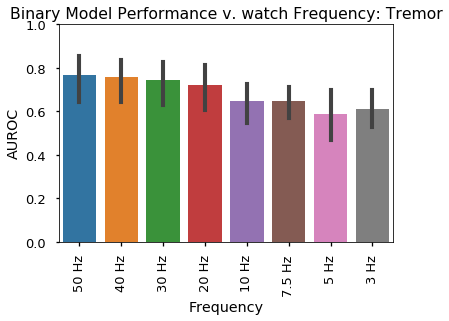

In [166]:
barplotFreq('watch','Tremor','Binary')
stats_tests('watch','Tremor','Binary')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.037126669145139186

50 Hz, 40 Hz, 30 Hz
p-value: 4.019522966970305e-07

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 2.103195438787061e-13

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 1.1803670966141557e-18

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 1.0223265351832662e-20

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 1.0851825169844313e-17

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 1.7537377245154837e-12

Minimum RMS: 3 Hz

3 Hz, 50 Hz
Ttest_relResult(statistic=-4.567578241344528, pvalue=0.0008065695829365212)
3 Hz, 40 Hz
Ttest_relResult(statistic=-5.6432239007516225, pvalue=0.0001503204635386621)
3 Hz, 30 Hz
Ttest_relResult(statistic=-3.3306723410508616, pvalue=0.006703260318294112)
3 Hz, 20 Hz
Ttest_relResult(statistic=-1.797920608409743, pvalue=0.09966103735658033)
3 Hz, 10 Hz
Ttest_relResult(statistic=-0.27685673264359945, pvalue=0.7870234007420458)
3 Hz, 7.5 Hz
Ttest_relResult(statistic=-0.682240283582

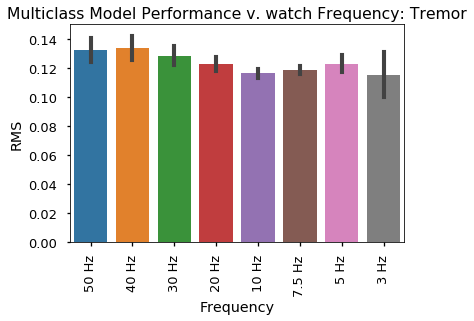

In [167]:
barplotFreq('watch','Tremor','Multiclass')
stats_tests('watch','Tremor','Multiclass')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 1.2455520759248735e-06

50 Hz, 40 Hz, 30 Hz
p-value: 0.0007091216106026705

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.06302204901456666

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.7902959222732905

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.3293600803370692

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.023826095989326612

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.0036230258395703575

Minimum RMS: 40 Hz

40 Hz, 50 Hz
Ttest_relResult(statistic=-9.488934085225663, pvalue=1.2455520759256443e-06)
40 Hz, 30 Hz
Ttest_relResult(statistic=-0.10862277507109185, pvalue=0.9154578057794914)
40 Hz, 20 Hz
Ttest_relResult(statistic=-1.1281720832048685, pvalue=0.28325271340721636)
40 Hz, 10 Hz
Ttest_relResult(statistic=-0.27594248475629424, pvalue=0.7877074891608553)
40 Hz, 7.5 Hz
Ttest_relResult(statistic=-1.871145676584908, pvalue=0.08814356472760215)
40 Hz, 5 Hz
Ttest_relResult(statistic=-1.9270910384574969, p

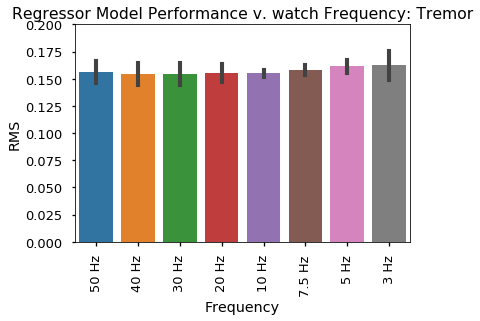

In [168]:
barplotFreq('watch','Tremor','Regressor')
stats_tests('watch','Tremor','Regressor')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.17468005710893278

50 Hz, 40 Hz, 30 Hz
p-value: 0.26421627484269494

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.06962541664189618

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.5480360853351334

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.5544211490530955

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.6784290583720296

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.5147691814678361

Maximum AUROC: 3 Hz

3 Hz, 50 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 40 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 30 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 20 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 10 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 7.5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)


C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


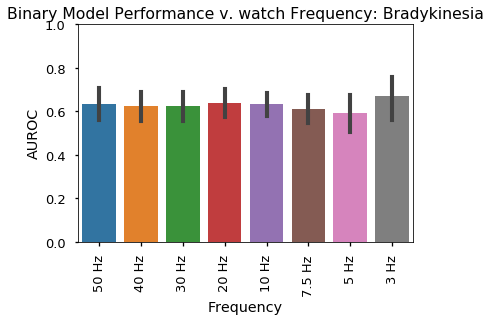

In [169]:
barplotFreq('watch','Bradykinesia','Binary')
stats_tests('watch','Bradykinesia','Binary')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.05478874693222728

50 Hz, 40 Hz, 30 Hz
p-value: 0.02996376005377043

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 1.7827122752466516e-06

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 1.0936805242244716e-14

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 6.239254767319909e-16

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 4.979855073168076e-23

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 4.091764297663831e-09

Minimum RMS: 20 Hz

20 Hz, 50 Hz
Ttest_relResult(statistic=-4.89598738795137, pvalue=0.0004746410436929494)
20 Hz, 40 Hz
Ttest_relResult(statistic=-4.770067574817093, pvalue=0.0005806170879489138)
20 Hz, 30 Hz
Ttest_relResult(statistic=-5.9915704128535765, pvalue=9.034888476631116e-05)
20 Hz, 10 Hz
Ttest_relResult(statistic=-7.527686973473427, pvalue=1.159413212063342e-05)
20 Hz, 7.5 Hz
Ttest_relResult(statistic=-7.314968237182077, pvalue=1.513870877519402e-05)
20 Hz, 5 Hz
Ttest_relResult(statistic=-10.03892471

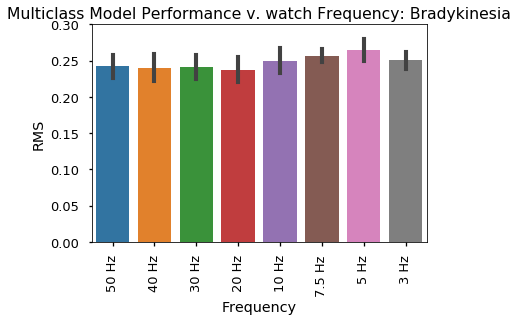

In [170]:
barplotFreq('watch','Bradykinesia','Multiclass')
stats_tests('watch','Bradykinesia','Multiclass')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.010653744158098628

50 Hz, 40 Hz, 30 Hz
p-value: 0.03075470482159677

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.4277141158397927

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 3.5820565530130613e-09

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 5.263213865550436e-22

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 3.113682110184279e-28

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 6.490078872493356e-07

Minimum RMS: 20 Hz

20 Hz, 50 Hz
Ttest_relResult(statistic=-1.1737176018139963, pvalue=0.2652950117644493)
20 Hz, 40 Hz
Ttest_relResult(statistic=-0.2642269976288235, pvalue=0.7964899895540078)
20 Hz, 30 Hz
Ttest_relResult(statistic=-0.22005496366219773, pvalue=0.8298589548039381)
20 Hz, 10 Hz
Ttest_relResult(statistic=-5.492554305463268, pvalue=0.00018833748115274775)
20 Hz, 7.5 Hz
Ttest_relResult(statistic=-8.141905268767788, pvalue=5.52440067610431e-06)
20 Hz, 5 Hz
Ttest_relResult(statistic=-8.482481352316025, 

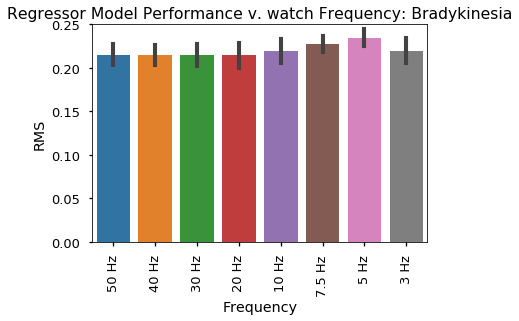

In [171]:
barplotFreq('watch','Bradykinesia','Regressor')
stats_tests('watch','Bradykinesia','Regressor')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.4463672994873166

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.6250422736472487

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.9376014379240305

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 0.18230282889464627

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.06195893813731402

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.004440782089529973

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.0006101523029957897

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.002265865397025805

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.0022928518508115348

Maximum AUROC: 60 Hz

60 Hz, 62.5 Hz
Ttest_relResult(statistic=0.7926713084401442, pvalue=0.44636729948733567)
60 Hz, 50 Hz
Ttest_relResult(statistic=0.10156691814136531, pvalue=0.9211081065075425)
60 Hz, 40 Hz
Ttest_relResult(statistic=0.14512559388960203, pvalue=0.88749513299938)
60 Hz, 30 Hz
Ttest_relResult(stat

C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


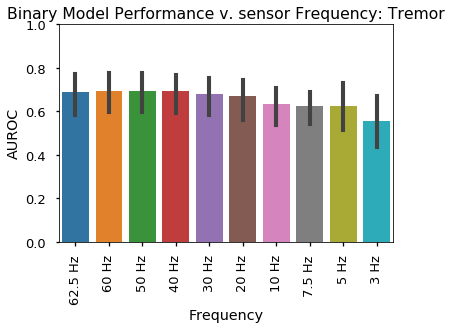

In [172]:
barplotFreq('sensor','Tremor','Binary')
stats_tests('sensor','Tremor','Binary')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.5370532240741168

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.1890134062329604

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.09573276388536642

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 0.1066914543419728

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.2628207950707688

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.5810188728275028

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.41839785326499696

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 7.358328816169059e-06

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 3.3534846955170977e-25

Minimum RMS: 10 Hz

10 Hz, 62.5 Hz
Ttest_relResult(statistic=-0.9867683488811818, pvalue=0.3449642564069453)
10 Hz, 60 Hz
Ttest_relResult(statistic=-0.7296393459335887, pvalue=0.4808596793499874)
10 Hz, 50 Hz
Ttest_relResult(statistic=-0.5811841625992265, pvalue=0.57283219997876)
10 Hz, 40 Hz
Ttest_relResult(statistic

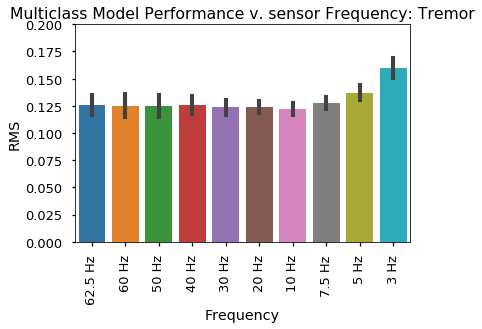

In [173]:
barplotFreq('sensor','Tremor','Multiclass')
stats_tests('sensor','Tremor','Multiclass')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.03530657570677893

62.5 Hz, 60 Hz, 50 Hz
p-value: 3.023259840884548e-07

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 3.481927918004493e-11

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 9.374011868884661e-12

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 9.15336221621203e-13

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 9.432387196654945e-16

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 5.2324488645217454e-15

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 1.4979835579629597e-21

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 6.866549230477222e-21

Minimum RMS: 62.5 Hz

62.5 Hz, 60 Hz
Ttest_relResult(statistic=-2.398814091819484, pvalue=0.035306575706779884)
62.5 Hz, 50 Hz
Ttest_relResult(statistic=-6.769347638583213, pvalue=3.076879677940804e-05)
62.5 Hz, 40 Hz
Ttest_relResult(statistic=-7.9849445385934015, pvalue=6.650238083133049e-06)
62.5 Hz

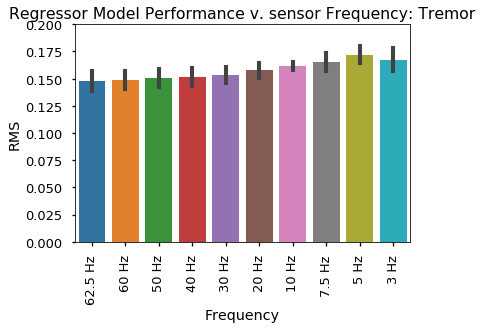

In [174]:
barplotFreq('sensor','Tremor','Regressor')
stats_tests('sensor','Tremor','Regressor')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.15808040096842946

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.14931293952550972

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.06742833672456362

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 0.11652902336414396

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.15358474335748948

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.17882864097098902

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.8257064165224169

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.09974500622553398

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.13880487679067038

Maximum AUROC: 3 Hz

3 Hz, 62.5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 60 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 50 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 40 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 30 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 20 Hz
Ttest_relR

C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


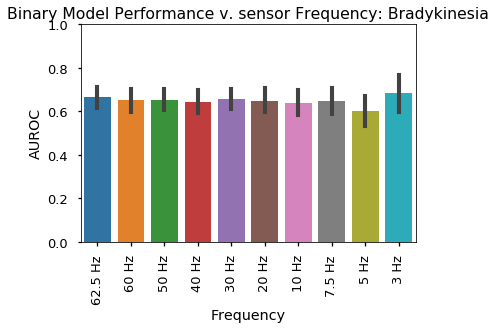

In [175]:
barplotFreq('sensor','Bradykinesia','Binary')
stats_tests('sensor','Bradykinesia','Binary')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 6.581008463279324e-05

62.5 Hz, 60 Hz, 50 Hz
p-value: 2.643166749991728e-06

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 4.231109586256397e-06

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 3.731067930228084e-07

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 1.4374146984667085e-10

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 7.047614856591786e-32

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 1.7921194269953587e-44

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 3.2927949437616455e-39

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 1.5027425851390103e-28

Minimum RMS: 20 Hz

20 Hz, 62.5 Hz
Ttest_relResult(statistic=-5.312225565367096, pvalue=0.00024772258283517804)
20 Hz, 60 Hz
Ttest_relResult(statistic=-3.6672764910288995, pvalue=0.0037072041568887615)
20 Hz, 50 Hz
Ttest_relResult(statistic=-4.368230504160842, pvalue=0.0011208355181450023)
20 Hz,

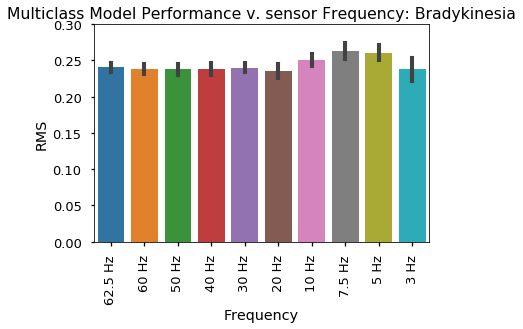

In [176]:
barplotFreq('sensor','Bradykinesia','Multiclass')
stats_tests('sensor','Bradykinesia','Multiclass')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.0079505603143379

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.0021045534474228495

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 4.9337864276411305e-09

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 3.24231619023126e-11

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 1.3795332972896092e-09

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 5.731517258255395e-09

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 1.6508977747434145e-20

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 2.4757755540439955e-18

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 4.458676529645024e-36


50 Hz, 60 Hz
Ttest_relResult(statistic=-2.9458392993568534, pvalue=0.013308046011058656)
50 Hz, 50 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
50 Hz, 40 Hz
Ttest_relResult(statistic=-8.46061747518173, pvalue=3.821244702773418e-06)
50 Hz, 30 Hz
Ttest_relResult(statistic=0.147595083089282, pvalue=0.

C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


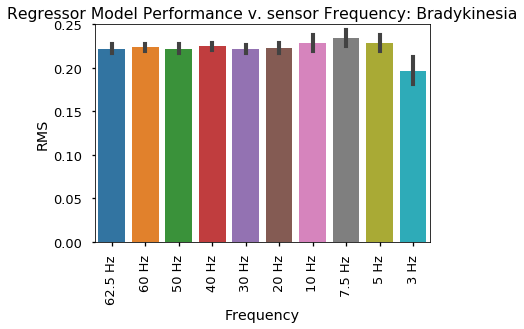

In [74]:
barplotFreq('sensor','Bradykinesia','Regressor')
stats_tests('sensor','Bradykinesia','Regressor')